In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import os

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import losses, optimizers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline


In [2]:
num_classes = 10
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# input image dimensions
img_rows, img_cols = 28, 28


In [3]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### Let's explore the data

In [4]:
if K.image_data_format() == 'channels_first':
    train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
    test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
    test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

print('train_images shape:', train_images.shape)
print('test_images shape:', test_images.shape)
print('train_labels shape:', train_labels.shape)
print('test_labels shape:', test_labels.shape)

print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

train_images shape: (60000, 28, 28, 1)
test_images shape: (10000, 28, 28, 1)
train_labels shape: (60000,)
test_labels shape: (10000,)
60000 train samples
10000 test samples


<AxesSubplot:xlabel='class', ylabel='prop'>

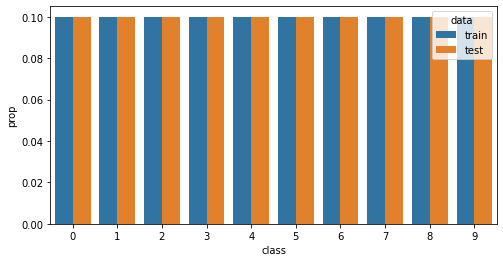

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_classes + ['test'] * num_classes),
    'class': np.tile(np.arange(num_classes), 2),
    'prop': np.hstack([np.bincount(train_labels) / train_labels.shape[0], 
                         np.bincount(test_labels) / test_labels.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)


In [6]:
y_counts.head()


,data,class,prop
0,train,0,0.1
1,train,1,0.1
2,train,2,0.1
3,train,3,0.1
4,train,4,0.1


The training dataset has the same proportion of each class, which is optimal to train a model so it can be trained with the same occurence of each class.

In the next cell, we illustrate the first elements of the training data: pixels grayscale of the clothes and their corresponding label.


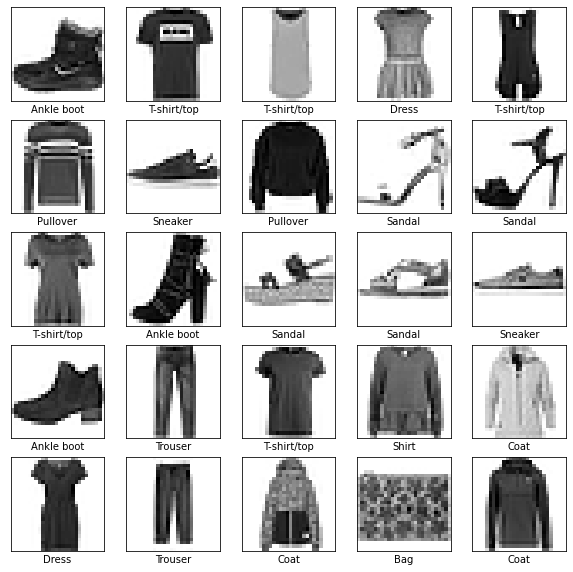

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


In [8]:
print(np.array2string(train_images[0].astype(np.int).reshape(28, 28), 
                      max_line_width=150))



[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 22

Each image can be visualized as a 28x28 matrix where each pixels is translated into a number from 0 to 255, corresponding to a shade of grey. The scale of grey goes from 0 (which correspond to white) to 255 (corresponds to black).

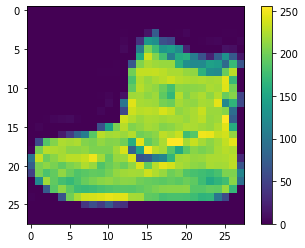

In [9]:
plt.figure()
plt.imshow(train_images[0].reshape(28,28))
plt.colorbar()
plt.grid(False)
plt.show()

There are 60 000 training images and 10 000 testing images. All the images are 28x28 pixels.

### Pre processing the data

Data cleaning is the first step in every machine learning exercise. However, this is a widely used dataset of images for praticing so the dataset is -almost- ready to be used. We still need to normalize the data.

### We normalize the data:

In [10]:
train_images = train_images / train_images.max()
test_images = test_images / test_images.max()


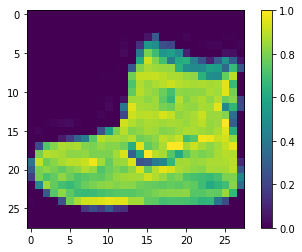

In [11]:
plt.figure()
plt.imshow(train_images[0].reshape(28,28))
plt.colorbar()
plt.grid(False)
plt.show()


The scale of grey is now from 0 to 1

In [12]:
# convert class vectors to binary class matrices
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
train_labels[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [13]:
train_labels.shape

(60000, 10)

In [14]:
test_labels.shape

(10000, 10)

### Creation of a validation set

We further split the train set into a train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

The actual training set will be divided into two groups:

    1.the training set
    2.the validation set

The latter is going to be used during the learning process of the model. Before training begin, we take a subset of the training set and label it has "validation data". Then, during the traiing process, the model will train on the training data and validate on the separated validation data. The model will, in addition in each epoch, predict on the validation set. The validation set is for us to see how general the model is on data not included on the training data. It will also help us to see if overfittig problem occurs.

We could notice two things:

    1.We could have used the "validation_split" argument of the fit function which directly set apart a fraction of the training data. The model will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.

    2.The "Mnist_fashion" dataset is pre shuffled but it is important to keep in mind that shuffling data serves the purpose of reducing variance and making sure that models remain general and overfit less. Shuffling makes sure that the training/test/validation sets are representative of the overall distribution of the data.


In [15]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=2020)



In [16]:
print("Fashion MNIST train -  rows:",train_images.shape[0]," columns:", train_images.shape[1:4])
print("Fashion MNIST valid -  rows:",valid_images.shape[0]," columns:", valid_images.shape[1:4])
print("Fashion MNIST test -  rows:",test_images.shape[0]," columns:", test_images.shape[1:4])


Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


In [17]:
valid_set= (valid_images,valid_labels)

### Builing the CNN models

Now that we are familiar with the data, let's dive into the real work: building a neural network that will be able to classify accurately new clothes images.

In this section, we are going to try to create the most efficient CNN by modifying the architecture of the model but also hyperparameters.


### First CNN

In [18]:
model_cnn = Sequential()
model_cnn.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn.add(Conv2D(128, kernel_size=(5, 5), activation='relu', name='conv2d_2'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1'))
model_cnn.add(Dropout(0.25, name='dropout_1'))
model_cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_3'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2'))
model_cnn.add(Dropout(0.25, name='dropout_2'))
model_cnn.add(Flatten(name='flatten'))
model_cnn.add(Dense(256, activation='relu', name='dense'))
model_cnn.add(Dense(num_classes, activation='softmax', name='output'))
                  
model_cnn.compile(loss=losses.categorical_crossentropy,
                  optimizer=optimizers.Adadelta(),
                  metrics=['accuracy'])

model_cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       204928    
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 4, 4, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0

$Epoch:$ One Epoch is when an entire dataset is passed forward and backward through the neural network only once. Since one epoch is too big to feed to the computer at once we divide it in several smaller batches. We need to pass the full dataset multiple times to the same neural network, this is why epoch isn't equal to 1. One of the critical issues while training a neural network on the sample data is Overfitting. It tends to happen when the number of epochs used to train a neural network model is "too high". We start with epochs=20 which generally is enough for the model to converge before overfitting.

$Batch Size$ It is a hyperparameter to tune too. The batch size is the number of samples that are passed to the network at once. We start with batch_size=32.

$Optimizer$ An optimizer update the weight parameters to minimize the loss function. We strat by using Adadelta.



In [19]:
#run the model
batch_size = 32
epochs = 5

# Run the train
history_cnn = model_cnn.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set)
score_cnn = model_cnn.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn[0])
print('Test accuracy:', score_cnn[1])



Epoch 1/5
1500/1500 [==============================] - 318s 212ms/step - loss: 2.2667 - accuracy: 0.1595 - val_loss: 2.2195 - val_accuracy: 0.3933
Epoch 2/5
1500/1500 [==============================] - 319s 213ms/step - loss: 2.0835 - accuracy: 0.3674 - val_loss: 1.9174 - val_accuracy: 0.4930
Epoch 3/5
1500/1500 [==============================] - 318s 212ms/step - loss: 1.6206 - accuracy: 0.4834 - val_loss: 1.4030 - val_accuracy: 0.5483
Epoch 4/5
1500/1500 [==============================] - 332s 221ms/step - loss: 1.2790 - accuracy: 0.5436 - val_loss: 1.1652 - val_accuracy: 0.6107
Epoch 5/5
1500/1500 [==============================] - 326s 217ms/step - loss: 1.1450 - accuracy: 0.5816 - val_loss: 1.0604 - val_accuracy: 0.6311
Test loss: 1.0631681680679321
Test accuracy: 0.6299999952316284


### Comment on the first neural network

The accuracy level on the training set is quite low (62%). With epochs=5, we see that the level of accuracy still increases. However, increasing the epochs hyperparameter is time-consuming for only small improvement in accuracy.

Instead, we are going to focus first on the kernel size used. Here, we used a 5x5 kernel size. The question raised is how to choose a kernel size ?

Most of the useful features in an image are usually local and it makes sense to take few local pixels at a time to apply convolutions. Most of these useful features may be found in more than one place in an image. So, it makes sense to slide a single kernel all over the image in the hope of extracting that feature in different parts of the image using the same kernel. Let's notice that even kernel size are skipped for implementation simplicity. Moreover, out input images are quite small (28x28). Hence, we should try using a 3x3 kernel (which is a popular choice).


### Second version of the CNN: changing the kernel size

In [20]:
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_2'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1'))
model_cnn2.add(Dropout(0.25, name='dropout_1'))
model_cnn2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_3'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2'))
model_cnn2.add(Dropout(0.25, name='dropout_2'))
model_cnn2.add(Flatten(name='flatten'))
model_cnn2.add(Dense(256, activation='relu', name='dense'))
model_cnn2.add(Dense(num_classes, activation='softmax', name='output'))
                    
model_cnn2.compile(loss=losses.categorical_crossentropy,
                  optimizer=optimizers.Adadelta(),
                  metrics=['accuracy'])

model_cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 256)       295168    
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 5, 5, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 256)        

In [22]:
#run the model
batch_size = 32
epochs = 5

# Run the train
history_cnn2 = model_cnn2.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=valid_set)
score_cnn2 = model_cnn2.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn2[0])
print('Test accuracy:', score_cnn2[1])

Test loss: 0.8469204902648926
Test accuracy: 0.6798999905586243


The second CNN achieve a slightly better accuracy level, both during training and on testing set. Hence, we can conclude that the 3X3 kernel size is more adapted to the fashion mnist images

### 3rd version of the CNN: Changing the optimizer

Instead of using Adadelta optimizer, we are trying to assess if other optimizers would build better predictive model. We are now using the 'Adam' optimizer. Adam: Adaptive Moment Estimation (Adam) is a method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients like Adadelta, Adam also keeps an exponentially decaying average of past gradients, similar to momentum.


In [23]:
model_cnn3 = Sequential()
model_cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_2'))
model_cnn3.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1'))
model_cnn3.add(Dropout(0.25, name='dropout_1'))
model_cnn3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_3'))
model_cnn3.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2'))
model_cnn3.add(Dropout(0.25, name='dropout_2'))
model_cnn3.add(Flatten(name='flatten'))
model_cnn3.add(Dense(256, activation='relu', name='dense'))
model_cnn3.add(Dense(num_classes, activation='softmax', name='output'))
                    
model_cnn3.compile(loss=losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

In [24]:
#run the model
batch_size = 32
epochs = 5

# Run the train
history_cnn3 = model_cnn3.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=valid_set)
score_cnn3 = model_cnn3.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn3[0])
print('Test accuracy:', score_cnn3[1])

Test loss: 0.24438250064849854
Test accuracy: 0.9132999777793884


Adam optimizer increased the accuracy level on the test set by 17% ! This is a major improvement. However, the gap between the accuracy on the training (98%) and the testing set illustrates the "over-fitting" phenomenon.

### 4th version of the CNN: Preventing overfitting

Both bias and variance are forms of prediction error in machine learning. Typically, we can reduce error from bias but might increase error from variance as a result, or vice versa. This trade-off between too simple (high bias) vs. too complex (high variance) is a key concept in statistics and machine learning, and one that affects all supervised learning algorithms. Here, we observe after 20 epochs that there is an increasing gap between the accuracy level on the training set and the validation/testing one. The accuracy level on the training set tends to increase to 99% while the accuracy on the validation set converges around 93%. Typically, the Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase. We tried to build a CNN without dropout layers and observed a large overfitting. We increased the dropout rate to 0.5. In passing 0.5, every hidden unit (neuron) is set to 0 with a probability of 0.5. In other words, there’s a 50% change that the output of a given neuron will be forced to 0. We try this method and the aftermaths were:

    1.Almost no more overfitting
    2.A slightly lower accuracy level on the testing set (91.3%)

We can use EarlyStopping, which is also a useful method to prevent overfitting. The patience argument corresponds to the number of epochs with no improvement after which training will be stopped. We decide to set it to 5.


In [25]:
model_cnn4 = Sequential()
model_cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_2'))
model_cnn4.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1'))
model_cnn4.add(Dropout(0.5, name='dropout_1'))
model_cnn4.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_3'))
model_cnn4.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2'))
model_cnn4.add(Dropout(0.5, name='dropout_2'))
model_cnn4.add(Flatten(name='flatten'))
model_cnn4.add(Dense(256, activation='relu', name='dense'))
model_cnn4.add(Dense(num_classes, activation='softmax', name='output'))
                    
model_cnn4.compile(loss=losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])


In [26]:
from tensorflow.keras.callbacks import EarlyStopping


In [27]:
#run the model
batch_size = 32
epochs = 5

# Run the train
history_cnn4 = model_cnn4.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
score_cnn4 = model_cnn4.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn4[0])
print('Test accuracy:', score_cnn4[1])

Epoch 1/5
1500/1500 [==============================] - 243s 162ms/step - loss: 0.4711 - accuracy: 0.8259 - val_loss: 0.3352 - val_accuracy: 0.8827
Epoch 2/5
1500/1500 [==============================] - 245s 163ms/step - loss: 0.3095 - accuracy: 0.8865 - val_loss: 0.2925 - val_accuracy: 0.8948
Epoch 3/5
1500/1500 [==============================] - 245s 163ms/step - loss: 0.2686 - accuracy: 0.8987 - val_loss: 0.2567 - val_accuracy: 0.9045
Epoch 4/5
1500/1500 [==============================] - 245s 163ms/step - loss: 0.2433 - accuracy: 0.9090 - val_loss: 0.2441 - val_accuracy: 0.9113
Epoch 5/5
1500/1500 [==============================] - 245s 164ms/step - loss: 0.2269 - accuracy: 0.9153 - val_loss: 0.2225 - val_accuracy: 0.9189
Test loss: 0.23340217769145966
Test accuracy: 0.9122999906539917


### Analysis of the results

###### Comparaison of accuracy and loss

In [28]:
# summarize history for accuracy

def history_accuracy(history_model):
  history = history_model
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
# summarize history for loss

def history_loss(history_model):
  history = history_model
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

FIRST CNN MODEL:


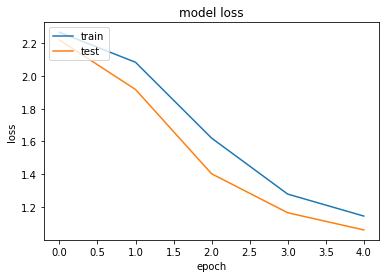

2ND CNN MODEL :


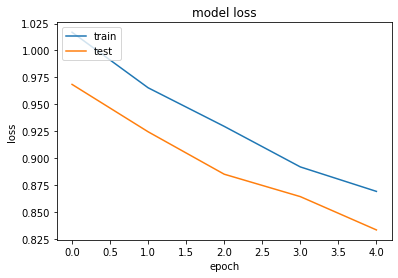

3RD CNN MODEL:


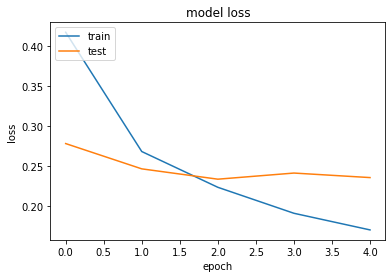

4TH CNN MODEL: 


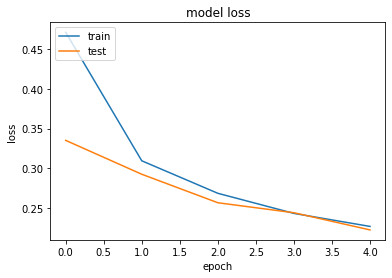

In [29]:
#Loss
print("FIRST CNN MODEL:" )
history_loss(history_cnn)
print("2ND CNN MODEL :")
history_loss(history_cnn2)
print("3RD CNN MODEL:")
history_loss(history_cnn3)
print("4TH CNN MODEL: ")
history_loss(history_cnn4)


The lower the loss, the better a model. The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets. In the case of neural networks, the loss is usually negative log-likelihood and residual sum of squares for classification and regression respectively.

By increasing the number of epochs, the loss would have probably continue to decrease for the 1st nd 2nd CNN. However, it stays at 1st a higher lever for those models than the last one. We note that the 3rd CNN's loss function of the test set diverges from the loss function of the train set. One would expect the reduction of loss after each, or several, iterations, which is clearly not the case for this model's test set.

The first and second models achieve lower accuracy level. However, the train and test accuracy levels are close enough to conclude that there is no overfitting. Overfitting is clearly observed in the 3rd model, and largely reduced in the 4th one.


FIRST CNN MODEL:


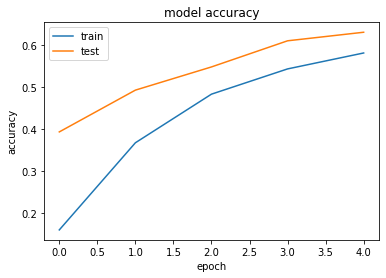

2ND CNN MODEL :


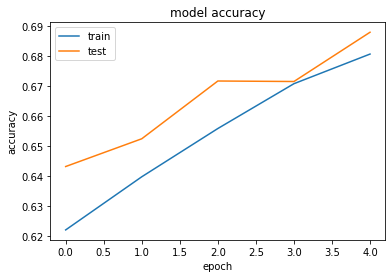

3RD CNN MODEL:


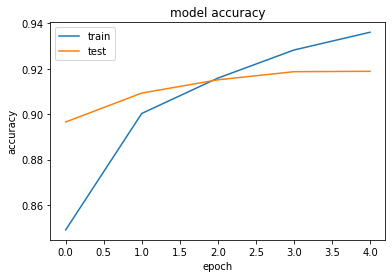

4TH CNN MODEL: 


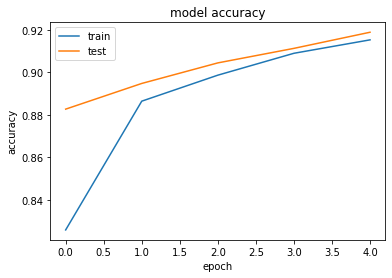

In [30]:
# Accuracy
print("FIRST CNN MODEL:" )
history_accuracy(history_cnn)
print("2ND CNN MODEL :")
history_accuracy(history_cnn2)
print("3RD CNN MODEL:")
history_accuracy(history_cnn3)
print("4TH CNN MODEL: ")
history_accuracy(history_cnn4)


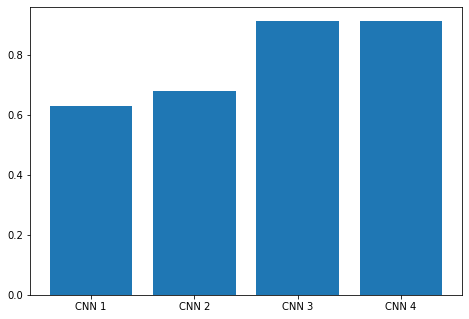

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
CNN = ['CNN 1', 'CNN 2', 'CNN 3', 'CNN 4']
Test_Accuracy = [score_cnn[1],score_cnn2[1],score_cnn3[1],score_cnn4[1]]
ax.bar(CNN,Test_Accuracy)
plt.show()

#### Which clothes are the harder to classify

In [32]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  true_label2=np.argmax(true_label)
  if predicted_label == np.argmax(true_label):
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label2]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  true_label2=np.argmax(true_label)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label2].set_color('blue')

In [33]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def plot_prediction_images(prediction):
  num_rows = 5
  num_cols = 3
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range (num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, prediction[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, prediction[i], test_labels)
  plt.tight_layout()
  plt.show()


### 1st CNN predictions

In [34]:
probability_model = tensorflow.keras.Sequential([model_cnn, 
                                         tensorflow.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)


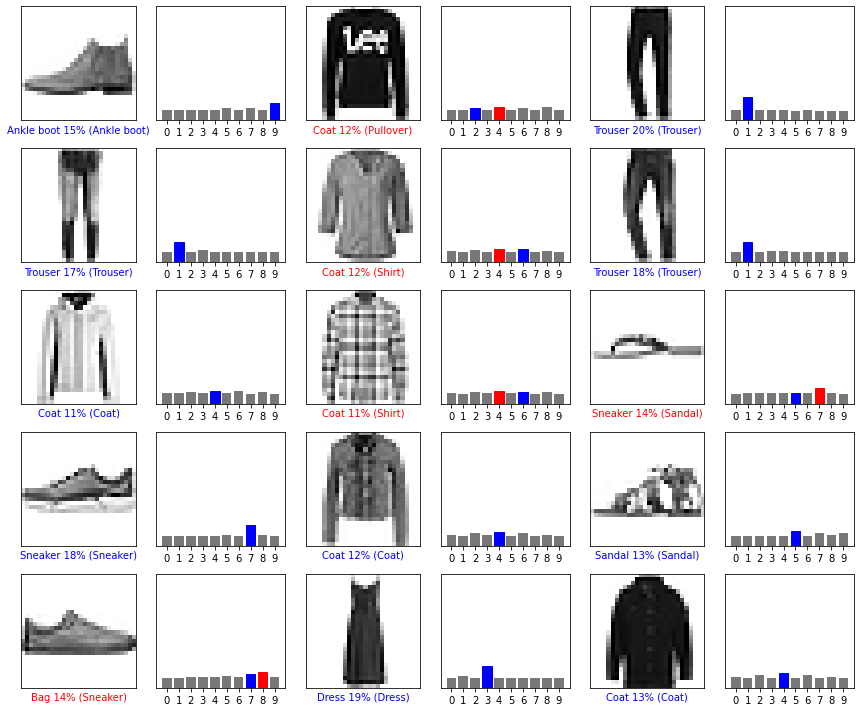

In [35]:
plot_prediction_images(predictions)



### 4th CNN predictions

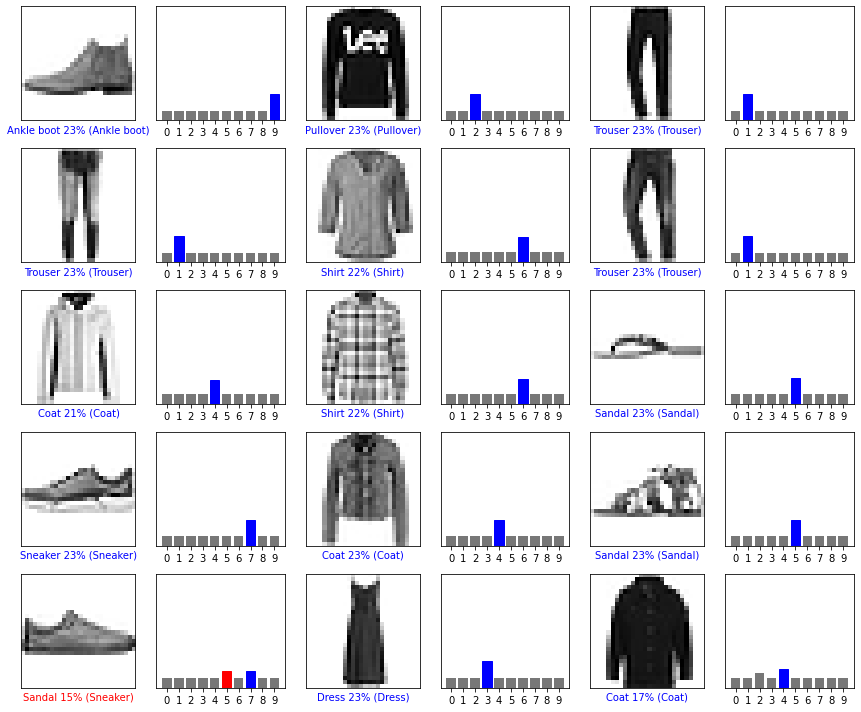

In [36]:
probability_model = tensorflow.keras.Sequential([model_cnn4, 
                                         tensorflow.keras.layers.Softmax()])
predictions4 = probability_model.predict(test_images)
plot_prediction_images(predictions4)



In [37]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools


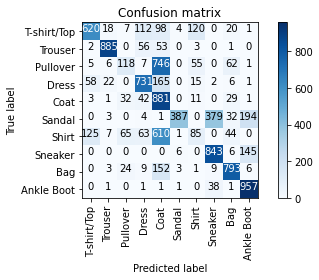

In [39]:
# Predict the values from the validation dataset
Y_pred = model_cnn.predict(test_images)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])


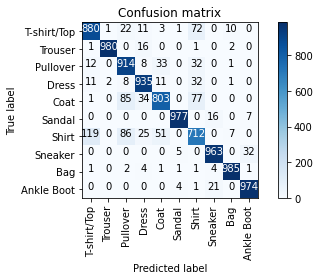

In [40]:
# Predict the values from the validation dataset
Y_pred = model_cnn4.predict(test_images)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])



Analysing the confusing matrixs, we conclude that shirt is the hardest type of clothe to classify. Our 4th model classifies "Shirt" more than 6 times better than the first CNN. It is still quite low compared to the other categories. The misclassification between 'T-Shirt/Top' and 'Shirt' often occurs; one is often classifies as the other.

On the other hand, 'Bag', 'Trouser' and 'Sandal' are the best classified categories in the 4th CNN. This can be explained by their very particular shapes, very different from the other items.


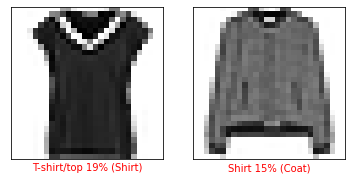

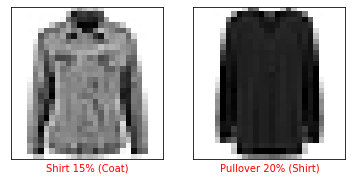

In [41]:
i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(977, predictions4[977], test_labels, test_images)
plt.subplot(1,2,2)
plot_image(905, predictions4[905], test_labels, test_images)
plt.show()

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(830, predictions4[830], test_labels, test_images)
plt.subplot(1,2,2)
plot_image(860, predictions4[860], test_labels, test_images)
plt.show()



T-Shirt and Shirt have a very close shape. Hence, the CNN detects a similar pattern of grey pixels. The fact that T-Shirt and Shirt can have long or short sleeves make it even more complicated for the CNN for correctly learn the pattern associated to one or the other of those two categories.

### Conclusion

Our best model achieve an accuracy level of 92% on the testing data set. Reducing the size of the kernel to 3x3 in each convolutional layers, changing for 'adam' optimizer and setting an earlystopping method were valuable to train our model.

After analysing the predictions of the best model, we realised that some categories were harder to classify than others. In general, upper-body clothes (T-Shirt, Shirt, Coat...) are difficult to identify because of they similar shape (i.e similar pixels patterns).

Last but not least, we could wonder if the model we just trained on the Fashion MNIST dataset would be directly applicable to images outside the Fashion MNIST dataset. For the answer to be yes, a lot of work would be needed on the newly used clothes images. Indeed, MNIST dataset images have already been processed (Converted to grayscale, Segmented,Resized) For real-world fashion and clothing images, you would have to preprocess your data in the same manner as the Fashion MNIST dataset. Even with this precaution, there's a high probability that the model doesn't accurately classify new images as they would be too different from the standardized mnist fashion one.
